Here we are, with the second part of the introduction! In this notebook we will see how to open fits files, what astronomical images really look like - they are a bit different than the great pictures you usually see! We'll go through everything together, so do not worry if this seems scary :)

In [1]:
# we import some packages, and define one convenience function for plotting

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits

def prep_plot(dim_x = 8, dim_y = 8):
    fig, ax = plt.subplots(1, 1, figsize = (dim_x, dim_y))
    return fig, ax

Before looking at astronomical images, it's better to have a look at a very simple image. We can generate the simplest image using a list of list, like this:


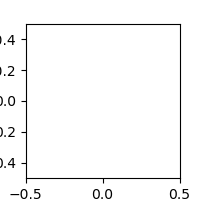

In [2]:
this_is_an_image = [[1]]

fig, ax = prep_plot(dim_x=2, dim_y=2)
ax.imshow(this_is_an_image, cmap = 'Greys');

The image is extremely simple, and quite boring to be honest. You can think of it as a single 'pixel', to which we associate an 'intensity' (1, in this case). We can make the figure a tiny bit less boring by adding three more pixels:

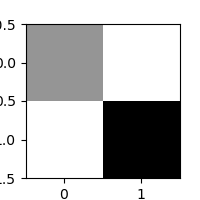

In [3]:
this_is_an_image = [[1, 0], [0, 2]]

fig, ax = prep_plot(dim_x=2, dim_y=2)
shown_image = ax.imshow(this_is_an_image, cmap = 'Greys');

You see now that our image has 4 pixels (equal to total number of elements in the the list of lists the are using). The colors have also changed: pixel with higher intensity are darker, while pixels with lower intensity are more white.
We can visualize this much better using a colorbar, that tells us which value is associated with which color:

In [4]:
plt.colorbar(shown_image) # when you execute this, the image above should change
plt.close()

Since our images are just lists of lists, we can also imagine to store the *absence* of intensity. This is different than setting the insity of the pixel to zero: zero is still something (for example, it means that no light was collected for a pixel), while the absence of a value might refer to the fact that a pixel was broken, or that we do not want to think about a pixel at all.

We represent the absence of a intensity using `Not a number`, or `NaN` for short. Python does not have a `NaN` on his own, and we have to use the `numpy` implemenetation of it: `np.nan`.

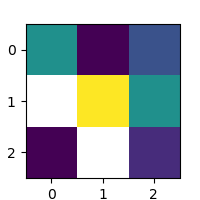

In [5]:
this_is_an_image = [[1, 0, 0.5], [np.nan, 2, 1], [0, np.nan, 0.25]]

fig, ax = prep_plot(dim_x=2, dim_y=2)
shown_image = ax.imshow(this_is_an_image);

I changed the colors to make it more apparent: you can see that the pixel we set as `NaN`have no color: Python knows that it should treat them as special pixels, and not colour them.

Believe it or not, our astronomical images will be very similar to this 4 pixel image; just a tiny bit bigger and more interesting to look at!

#### A bit uncorrelated, but I think it's insteresting :)
(This is probably not entirely accurate, but it should be close enough...) What I've shown earlier is, effectively, a grey scale image: black means that a lot of light hit the detector at that point, white the opposite. And, as a matter of fact, all images are just greyscale images: if we want to get colors we need to overlap at least three greyscale images on different bands (three is, I believe, the minimum. An additional greyscale image can be included, to make areas transparent)

We can try to use Python to create a coloured image and illustrate this a bit better:

In [6]:
# this seems much harder than it actually is, if you want we can see what everything does together :)

# credit for the picture: ESO/H. Drass et al.
# credit for the code: https://stackoverflow.com/questions/9166400/convert-rgba-png-to-rgb-with-pil (adapted from here)
from PIL import Image

def get_rgb(path):
    image = Image.open(path)
    image.load()
    r, g, b = image.split()
    image.close()
    return r, g, b

def get_band(path): 
    band_list = []
    for band in get_rgb(path):
        _, _, width_x, witdth_y = band.getbbox()
        band_list.append(np.array(band.getdata()).reshape(witdth_y, width_x))
    return np.array(band_list)

def plot_color_image(path, r_mult = 1, g_mult = 1, b_mult = 1):
    r, g, b = get_band(path)
    _plot_color_image((r * r_mult).astype(int), (g * g_mult).astype(int), (b * b_mult).astype(int))

def _plot_color_image(r, g, b):
    image = np.stack((r, g, b), axis = 2)
    fig, ax = prep_plot()
    ax.imshow(image)

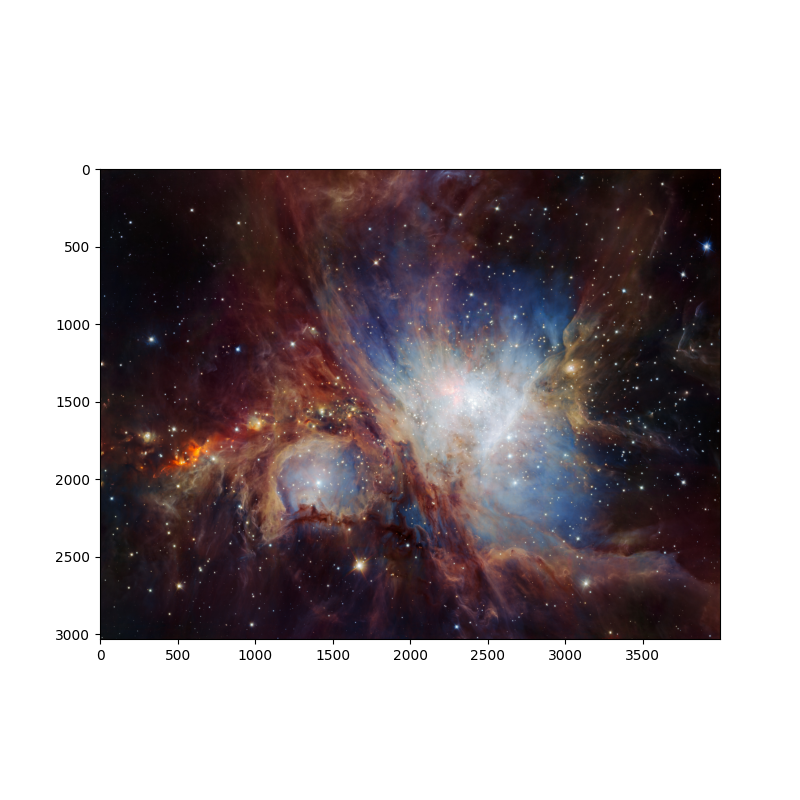

In [91]:
plot_color_image("./eso1625a.jpg")

# play around with different values to see what comes out of the image

The image looks wonderful! It is a stack of three single band images (red, green and blue), plotted on top of each other with some computer magic sprinkled on top to make everything work together. We can also take a look at a single image if we turn off two of the three channels. If we want to look at the red band, for example:

In [7]:
r, _, _ = get_band("./eso1625a.jpg")

We can also print `r` or plot it all alone:

In [8]:
print(r)

[[28 27 27 ... 11 12  9]
 [28 27 27 ... 12 13 12]
 [27 27 26 ... 14 14 16]
 ...
 [11 16 22 ... 58 58 55]
 [14 18 23 ... 58 57 51]
 [15 18 20 ... 60 57 48]]


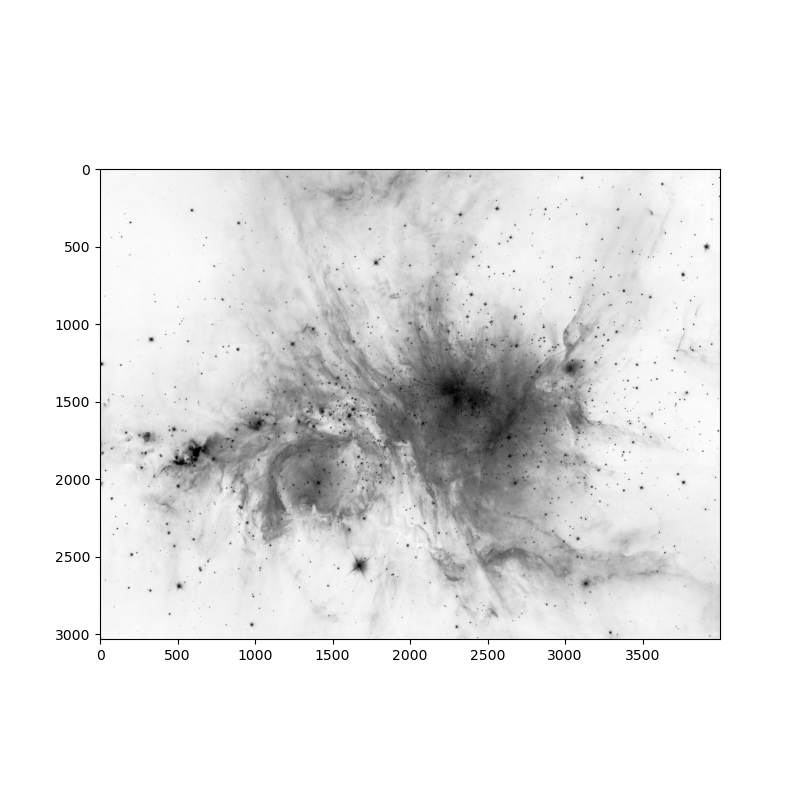

In [9]:
fig, ax = prep_plot()

ax.imshow(r, cmap = 'Greys')

You see that, under the hood, this is the same image we defined before with our list of lists. The difference is that we are using more pixels, and we have a more interesting subject to draw :)

### The fits file format
Now that we have an idea of what an image is (just a list of lists), we can turn to astronomical images.  
**File format:** Astronomical data we take from the telescope are always stored in a `.fits` format. It is extremely flexible, easy to use and manipulate, and great for long term storage, because we can also store metadata together with the data themselves. Python allows us to open fits files easily, using functions from the Astropy package.

In the following, we will open a fits file, and plot an image based on it using Python. Some of things we use here are used also for building the light curve, so we will most likely recycle some code.  
We will do everything together, so just make sure you are following along and understand what functions are doing.

In [10]:
# we open the fits file
f = fits.open("./ngc6543_optical_G.fits") 

A fits file is a collection of 'Header data units', or HDU for short. As the name suggests, each 'header data unit' is a combination of an `header`, and some `data`. The `header` contains the metadata, the `data` the telescope image.  
Every fits file has at least one HDU, called 'Primary HDU'. Additional ones can be added, and they are generally referred to as 'extensions'.

We can easily list the content of a fits file using the `.info()` method:

In [11]:
f.info()

Filename: ./ngc6543_optical_G.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      31   (3600, 3600)   int16 (rescales to uint16)   


You see here that the image we are using as example has only one HDU (which is also the Primary HDU).  
There are also some additional information:
- cards: is the number of metadata entries in the header (see cell below, it's going be clearer in a second)
- dimensions: the number of pixels of the image
- format: what is the data type for the pixel intensity. In this case, uint16 mean 'Unsigned integer 16', which means that each intensity value is stored in a format that only supports integer numbers > 0, where each integer is represent using 16 bits - it's hard to explain using words, come knock and we can go more into details :) It is not important for us in any case, it is mostly to reduce memory consumption when using the data.

We can look at the header of the HDU:

In [12]:
f[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 3600 / length of data axis 1                          
NAXIS2  =                 3600 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
PROGRAM = 'PixInsight 01.08.03.1123' / Software that created this HDU           
COMMENT PixInsight Class Library: PCL 02.00.13.0692                             
COMMENT FITS module version 

As you can see, the header if just a bunch of information with some comments. You see for instance the coordinate of the object in the sky, the software that created the fits image, and some information relative to the image itself - here it says that the image is a grayscale image (black and white image).

What Python called 'Cards' are just the list of names you see on the right, written in capital letters. We can check they are indeed 31:

In [13]:
header_cards = f[0].header.keys()

c = 0
for i in header_cards:
    c = c + 1
    
print(c)

31


We can also take a look at the data store in the HDU. To do so, we ask Python for the `data`:

In [14]:
data = f[0].data
f.close()
data

array([[771, 771, 514, ...,   0,   0,   0],
       [771, 514, 514, ...,   0,   0,   0],
       [514, 514, 257, ...,   0,   0,   0],
       ...,
       [257, 257,   0, ...,   0,   0,   0],
       [257, 257,   0, ...,   0,   0,   0],
       [257, 257,   0, ..., 257,   0,   0]], dtype=uint16)

The data of the image, as we saw earlieri, is just a bunch of numbers, stored in something that looks like a list of lists (well, the numpy equivalent of a list of lists)..

We can check the number of pixels for the image matches what `.info()` was telling us earlieri using the `shape` method:

In [15]:
print(data.shape) # it was not lying!

(3600, 3600)


Our image is quite big! 3600 x 3600 pixels!  
Finally, we can plot the image using matplotlib:

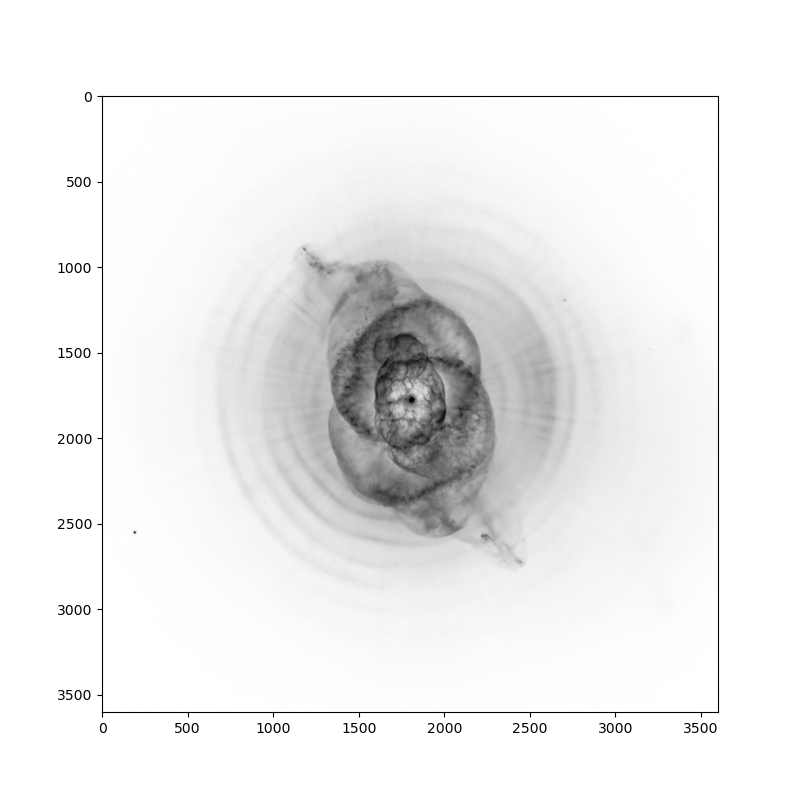

In [16]:
fig, ax = prep_plot()

ax.imshow(data, cmap = 'Greys');

Great! Now we know how to open a fits file, and create a plot of the data it contains. Having to repeat the same thing many times is very boring, so we can write a function that does everything we did earlier at the same time, and that we can reuse for other images:

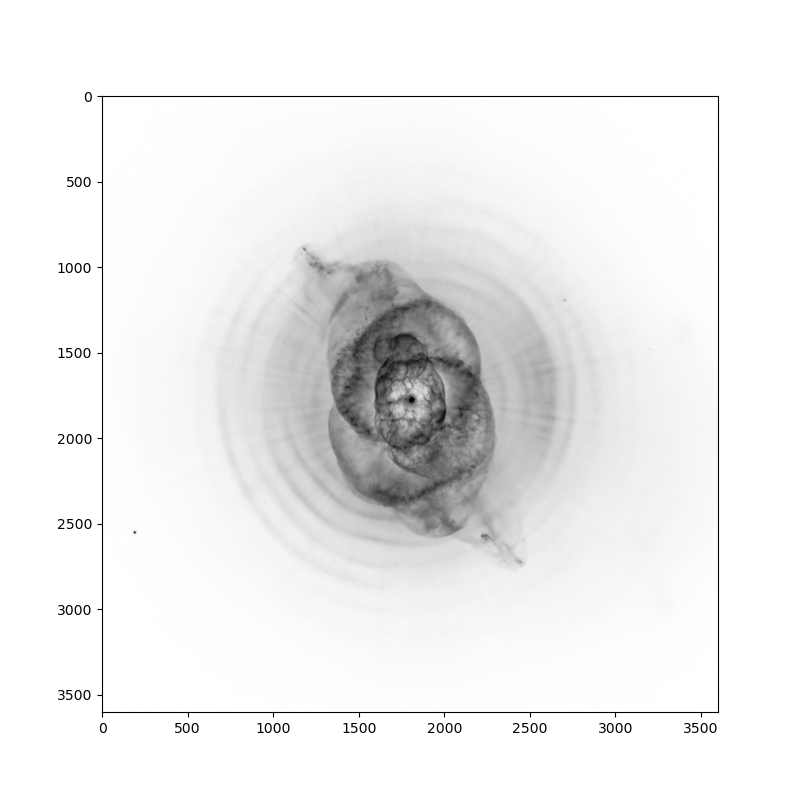

In [17]:
def plot_fits(path):
    fig, ax = prep_plot()
    
    with fits.open(path) as f: # this is the same as f = fits.open() ... f.close(), in a more compact format
        data, header = f[0].data, f[0].header
        
    ax.imshow(data, cmap = 'Greys')
    return data, header

plot_fits("./ngc6543_optical_G.fits");

Let's try to use it for one our images

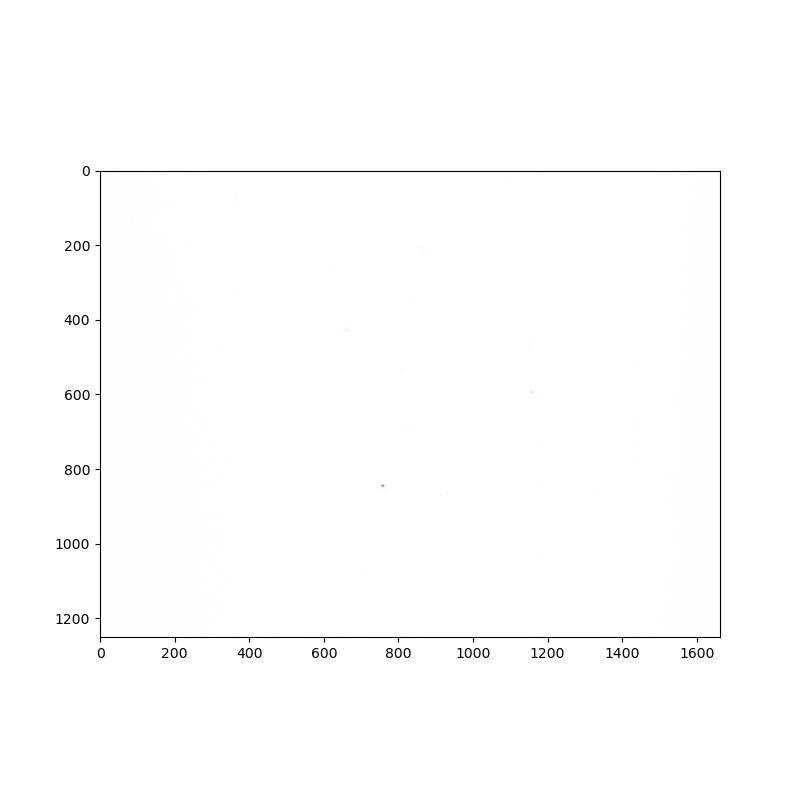

In [18]:
plot_fits("./SZ_Lyn/R/SZ_Lyn-0001R.fit");

Ugh! It seems like our image is empty! Was the telescope broken?  
Looking more carefully however, you can see a small black spot, but not much else...

There are (at least) two reasons:  
- the star is so much brighter than the background that the colorscale is completely messed up. We say that there is not enough [dynamic range](https://en.wikipedia.org/wiki/Dynamic_range). Indeed, we can take a look at the average pixel intensity value and compare it with the maximum intensity value:
```
print(np.mean(f[0].data)) -> 1540
print(np.max(f[0].data)) -> 65317
```
This means that most of pixels in the image are close to zero intensity, and as such will appear white, while the few pixels with very high intensity will be the only ones that are black. 
- the patch of sky where the star is is a lot more boring that the the field with the image we showed earlier, so there is not much to see anyway...
- (the telescope we used to take the image is a lot less powerful than the one used for the other image, so we do not see a lot of the details...)

We can go 'fix' the first issue by changing the colormap we are using for the image. To do so, we modify the plotting function as follows:

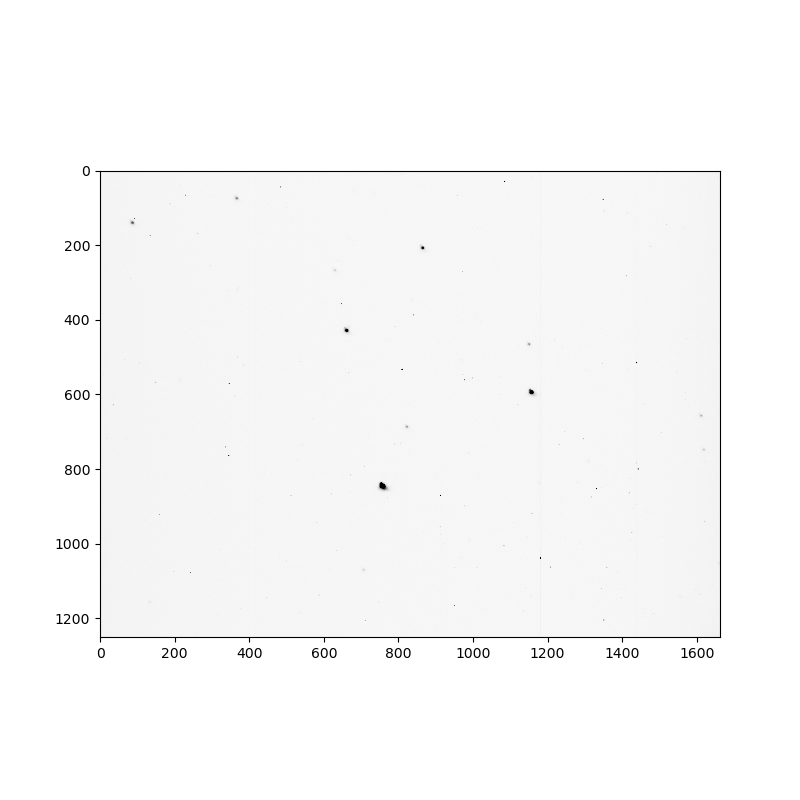

In [19]:
def plot_fits(path, vmax = None):
    fig, ax = prep_plot()
    
    with fits.open(path) as f:
        data, header = f[0].data, f[0].header
    if vmax is None:  
        ax.imshow(data, cmap = 'Greys')
    else:
        ax.imshow(data, cmap = 'Greys', vmax = vmax)
    return data, header

plot_fits("./SZ_Lyn/R/SZ_Lyn-0001R.fit", vmax = np.median(data));

This changes the color scale, so that the 'black' of the colorscale is the maximum value `vmax` we set, and everything with a pixel value higher than `vmax` is also black, but does not change the colormap. This makes evident other details that were hidden by the wonky colormap: you can see other objjects in the field (most likely other stars), and some defects of the detector (the vertical line you see at around x ~ 1200).

This is one of the images we will use to build the light curve, and it was taken with a small telescope in 2019.

Good job! We know everything we need now, and we can start with the real analysis.

In [ ]:
https://chandra.harvard.edu/photo/openFITS/